# ARIMA Model for APPLE Stocks
-Mannat Soni

## Step1: Importing libraries

In [1]:
!pip install --user statsmodels

In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

%config InlineBackend.figure_format = 'retina'

## Step 2: Import Data into pandaframes

In [9]:
df=pd.read_csv("AAPL1.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,12-12-1980,0.128348,0.128906,0.128348,0.128348,0.100751,469033600
1,15-12-1980,0.122210,0.122210,0.121652,0.121652,0.095495,175884800
2,16-12-1980,0.113281,0.113281,0.112723,0.112723,0.088485,105728000
3,17-12-1980,0.115513,0.116071,0.115513,0.115513,0.090676,86441600
4,18-12-1980,0.118862,0.119420,0.118862,0.118862,0.093304,73449600


Setting date column to index

In [10]:
df['Date']=pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100751,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095495,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088485,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090676,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093304,73449600


## Step 3: Preparing data for ARIMA

The first step in our data preparation is to resample the data such that stock closing proces are aggregated on a weekly basis.

In [13]:
df_week=df.resample('w').mean()
df_week=df_week[['Close']]
df_week.head()

,Close
Date,
1980-12-14,0.128348
1980-12-21,0.118973
1980-12-28,0.143415
1981-01-04,0.144531
1981-01-11,0.110602


Let's create a column for weekly returns. Take the log of the returns to normalize large functions.

In [14]:
df_week['weekly_ret']=np.log(df_week['Close']).diff()
df_week.head()

,Close,weekly_ret
Date,,
1980-12-14,0.128348,NaN
1980-12-21,0.118973,-0.075847
1980-12-28,0.143415,0.186844
1981-01-04,0.144531,0.007753
1981-01-11,0.110602,-0.267554


In [16]:
# dropp null rows
df_week.dropna(inplace=True)

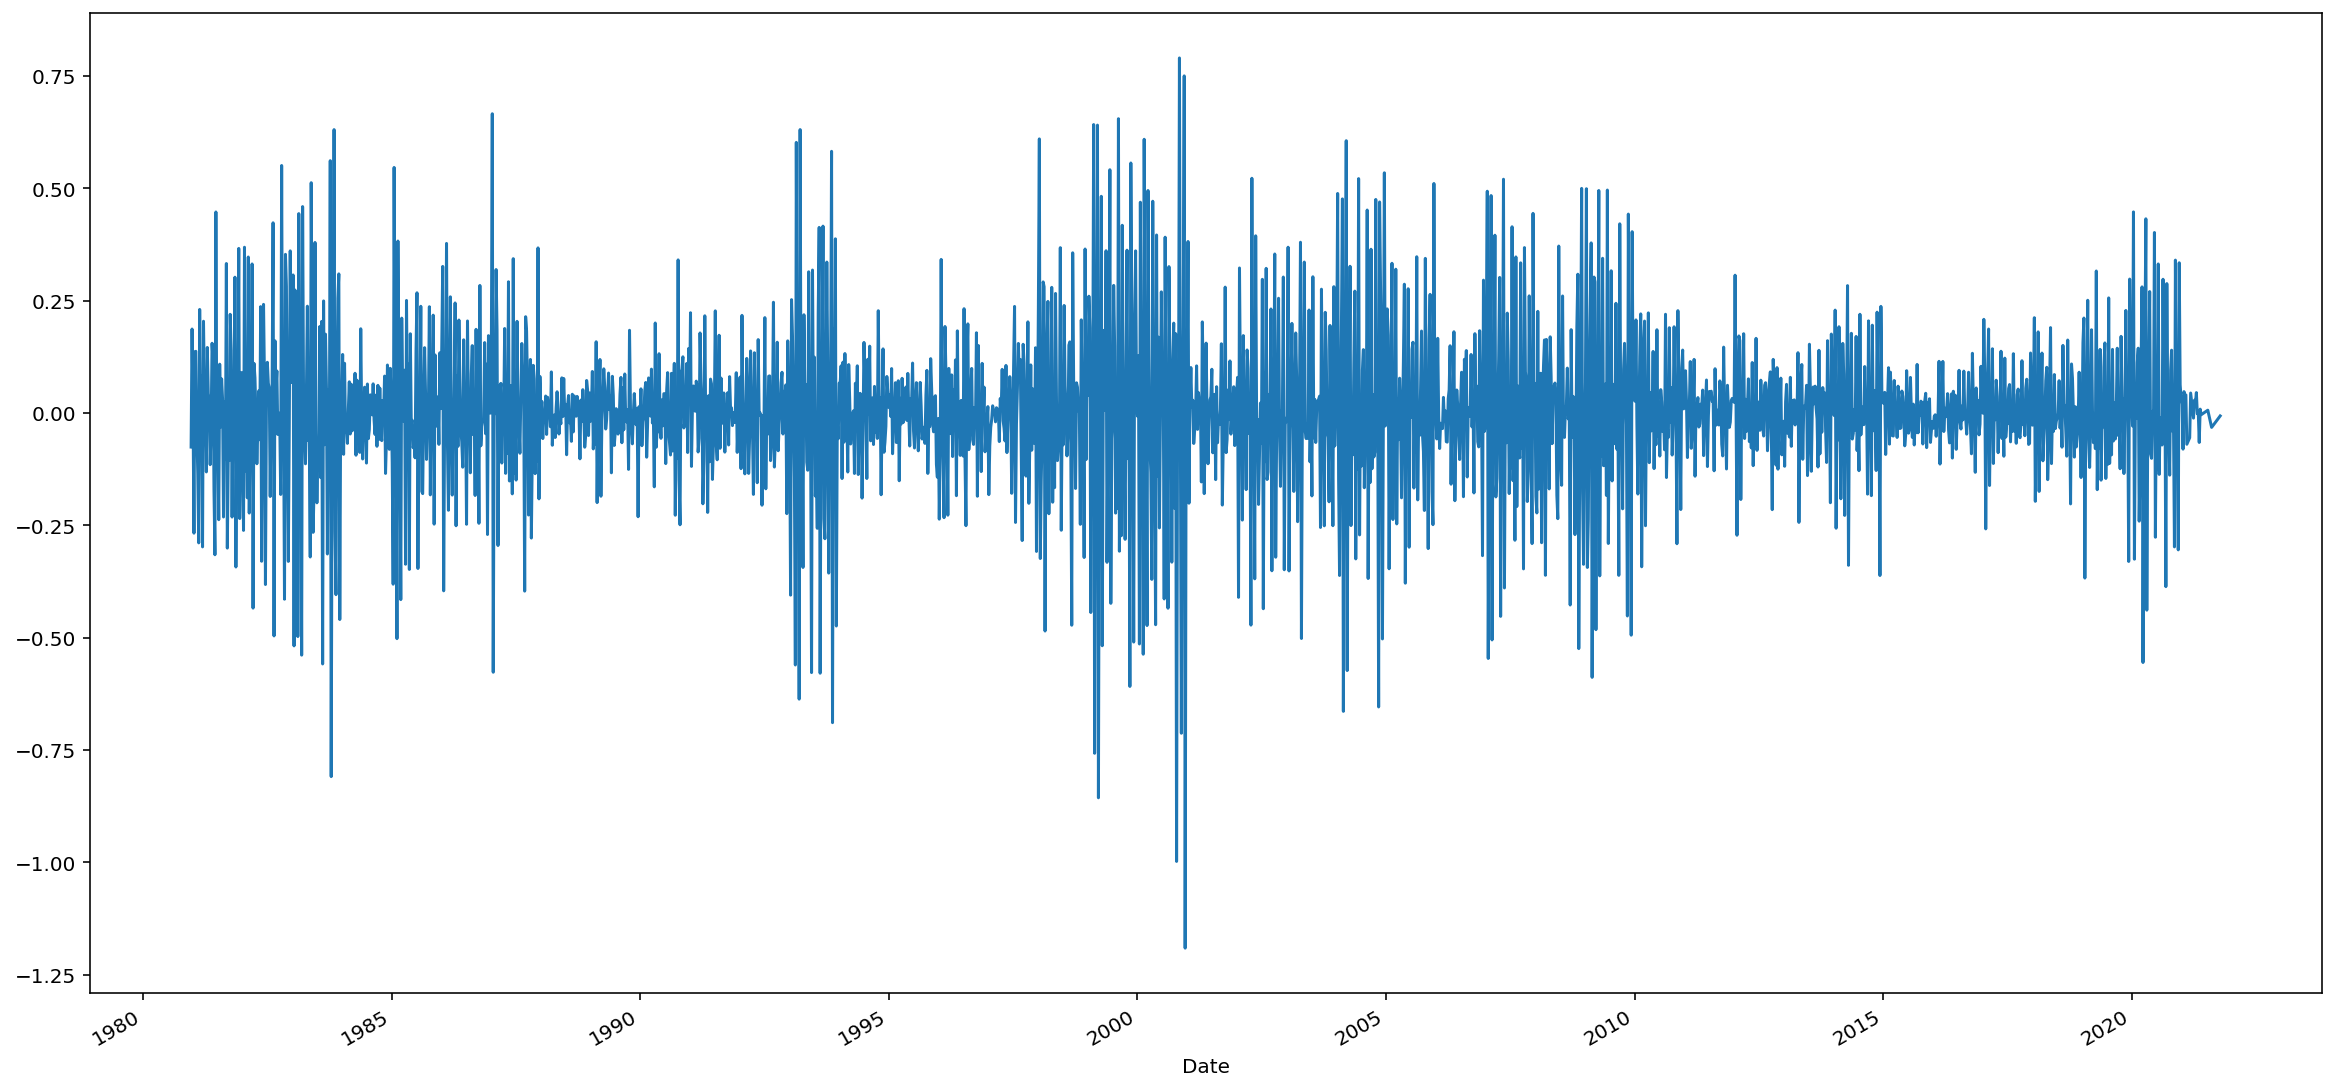

In [25]:
#Lets plot log of weekely results
df_week.weekly_ret.plot(kind='line', figsize=(20,10));

In [18]:
udiff=df_week.drop(['Close'], axis=1)
udiff.head()

,weekly_ret
Date,
1980-12-21,-0.075847
1980-12-28,0.186844
1981-01-04,0.007753
1981-01-11,-0.267554
1981-01-18,0.136557


## Step 4: Test for Stationarity of the udiff series
Time series are stationary if they do not contain trends or seasonal swings. The Dickey-Fuller test can be used to test for stationarity.

In [19]:
# importing required libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [20]:
rolmean=udiff.rolling(20).mean()
rolstd=udiff.rolling(20).std()

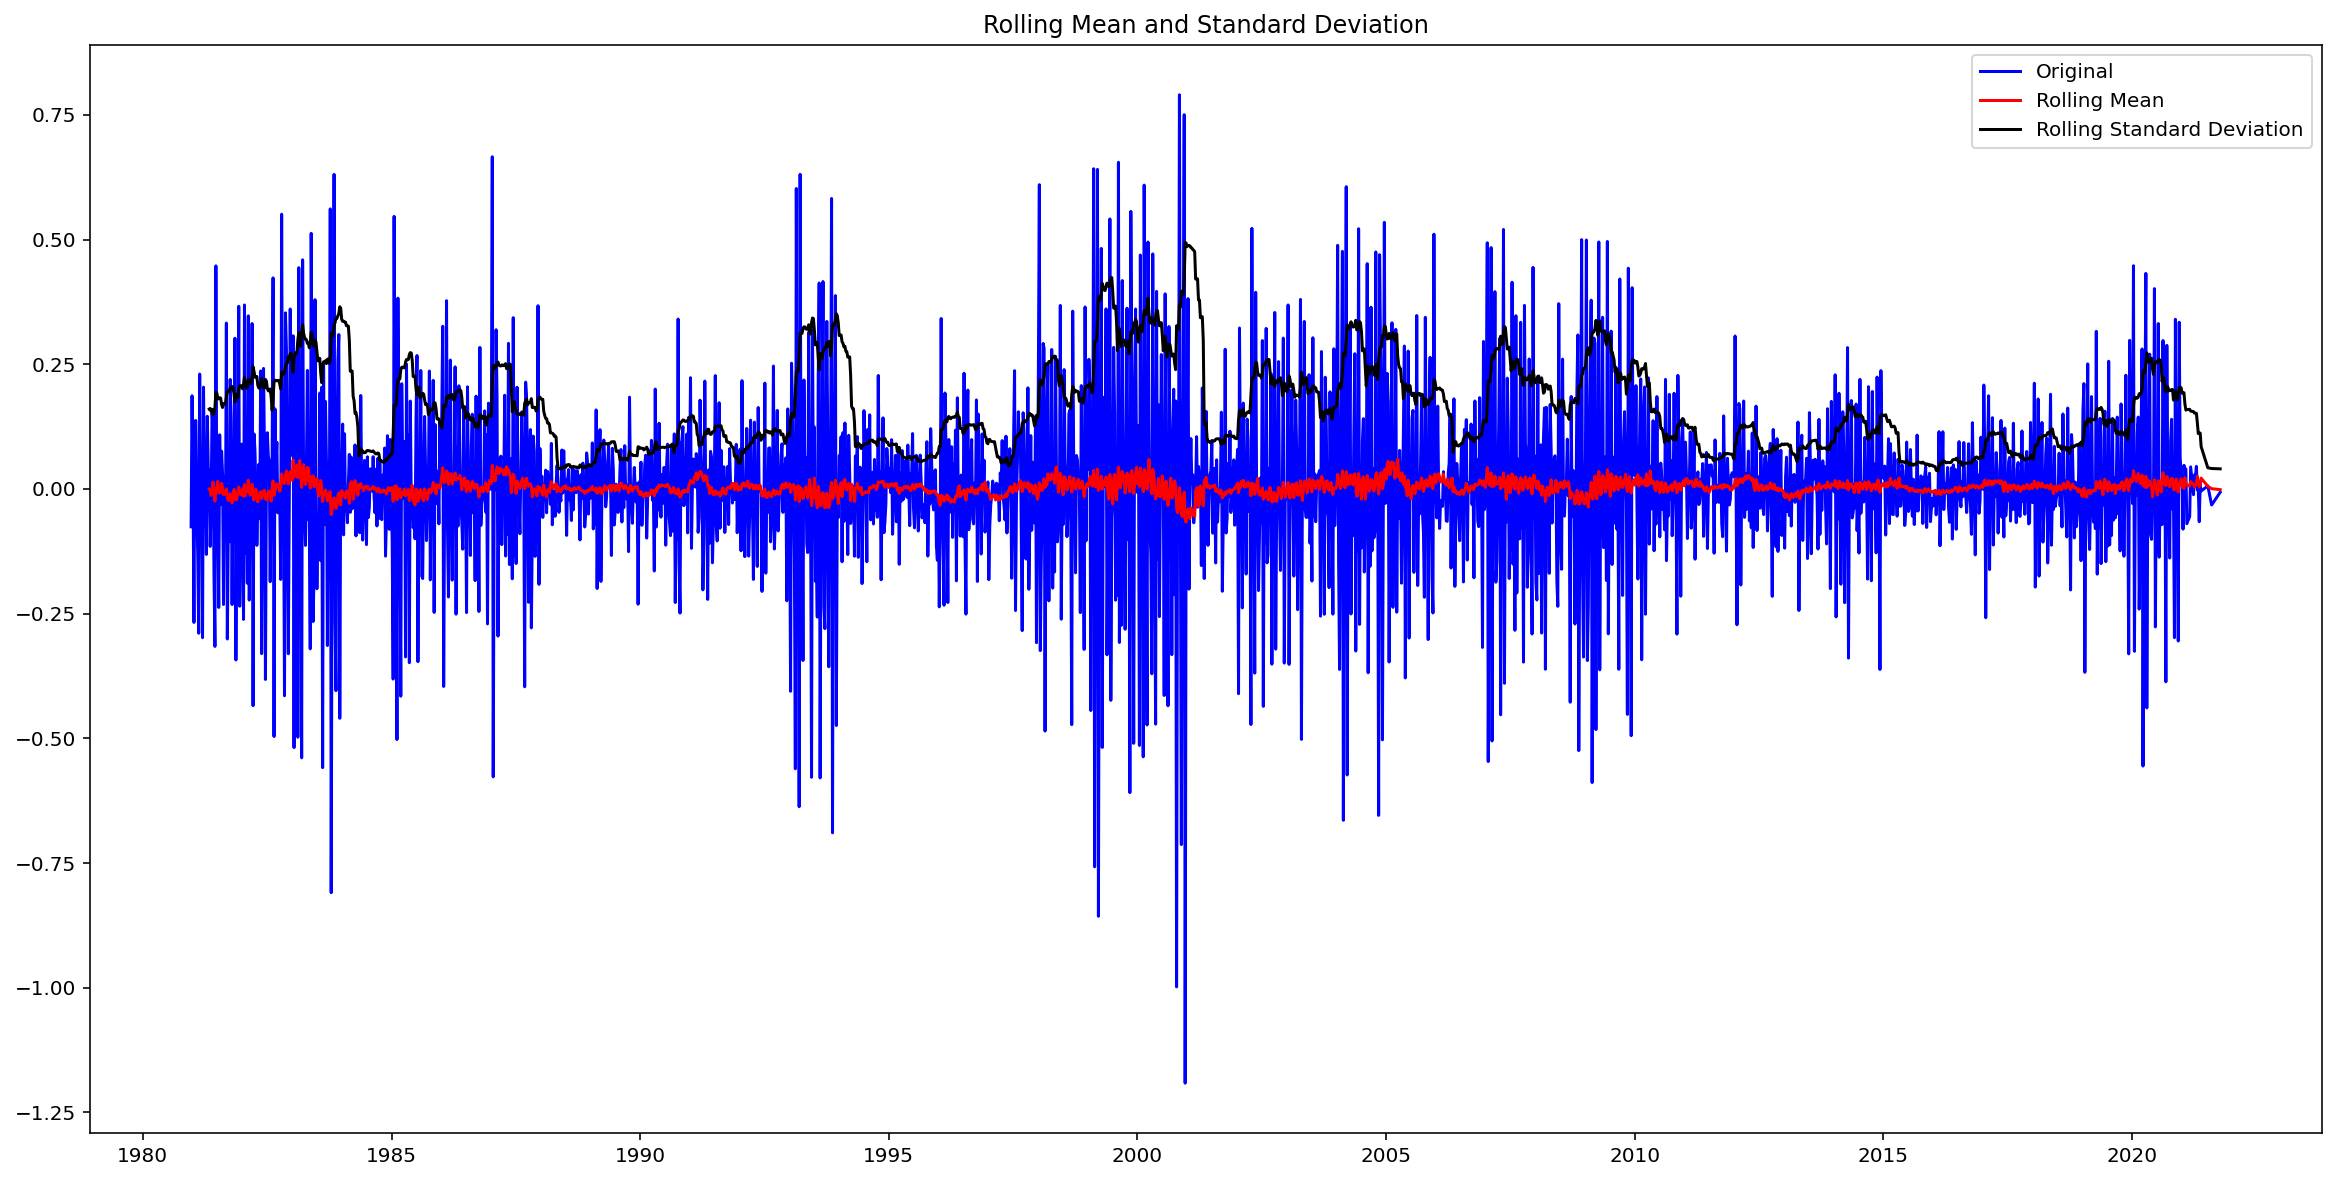

In [28]:
plt.figure(figsize=(20,10))
original=plt.plot(udiff, color='blue', label='Original')
mean=plt.plot(rolmean, color='red', label='Rolling Mean')
std=plt.plot(rolstd, color='black', label= 'Rolling Standard Deviation')
plt.title('Rolling Mean and Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

### Perform Dickey-Fuller Test

In [35]:
dftest=sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value({0})'.format(key)]=value

dfoutput

Test Statistic                -9.159376e+00
p-value                        2.557595e-15
#Lags Used                     2.200000e+01
Number of Observations Used    2.086000e+03
Critical Value(1%)            -3.433489e+00
Critical Value(5%)            -2.862927e+00
Critical Value(10%)           -2.567508e+00
dtype: float64

With a p-value < 0.05, we can now reject the null hypothesis. This dataset is stationary.

## Step 5: ACF and PADF Charts
Making autocorrelation and partial autocorrelation charts help us choose hyperparameters for the ARIMA model.

The ACF gives us a measure of how much each "y" value is correlated to the previous n "y" values prior.

The PACF is the partial correlation function gives us (a sample of) the amount of correlation between two "y" values separated by n lags excluding the impact of all the "y" values in between them.

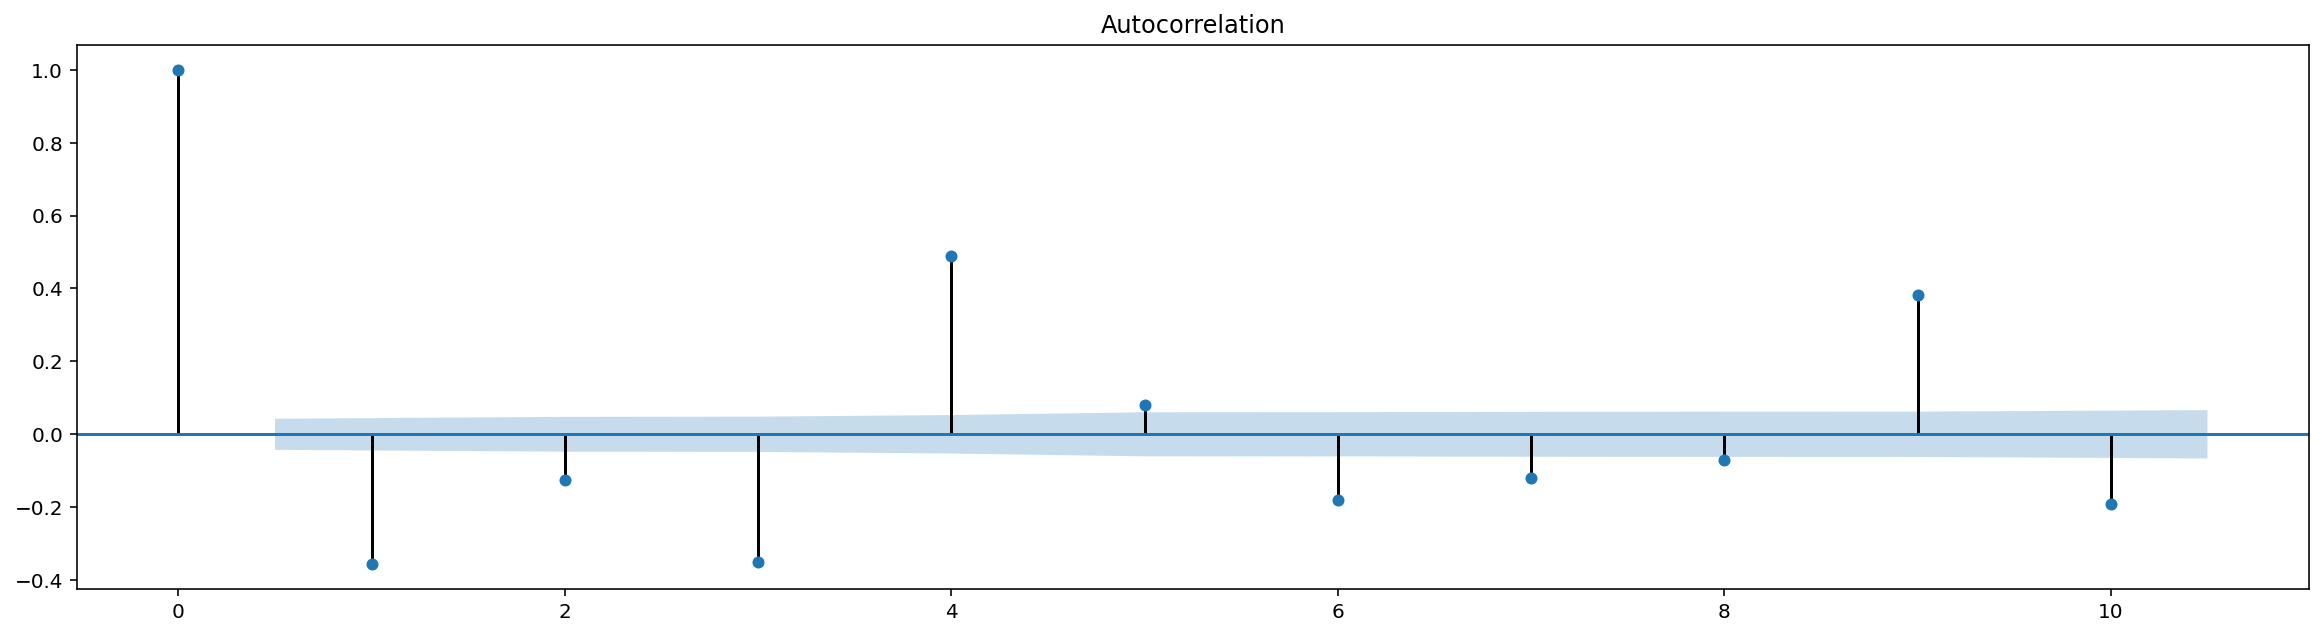

In [38]:
from statsmodels.graphics.tsaplots import plot_acf

#the autocorrelation chart provides just the correlation at increasing lags
fig, ax=plt.subplots(figsize=(20,5))
plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

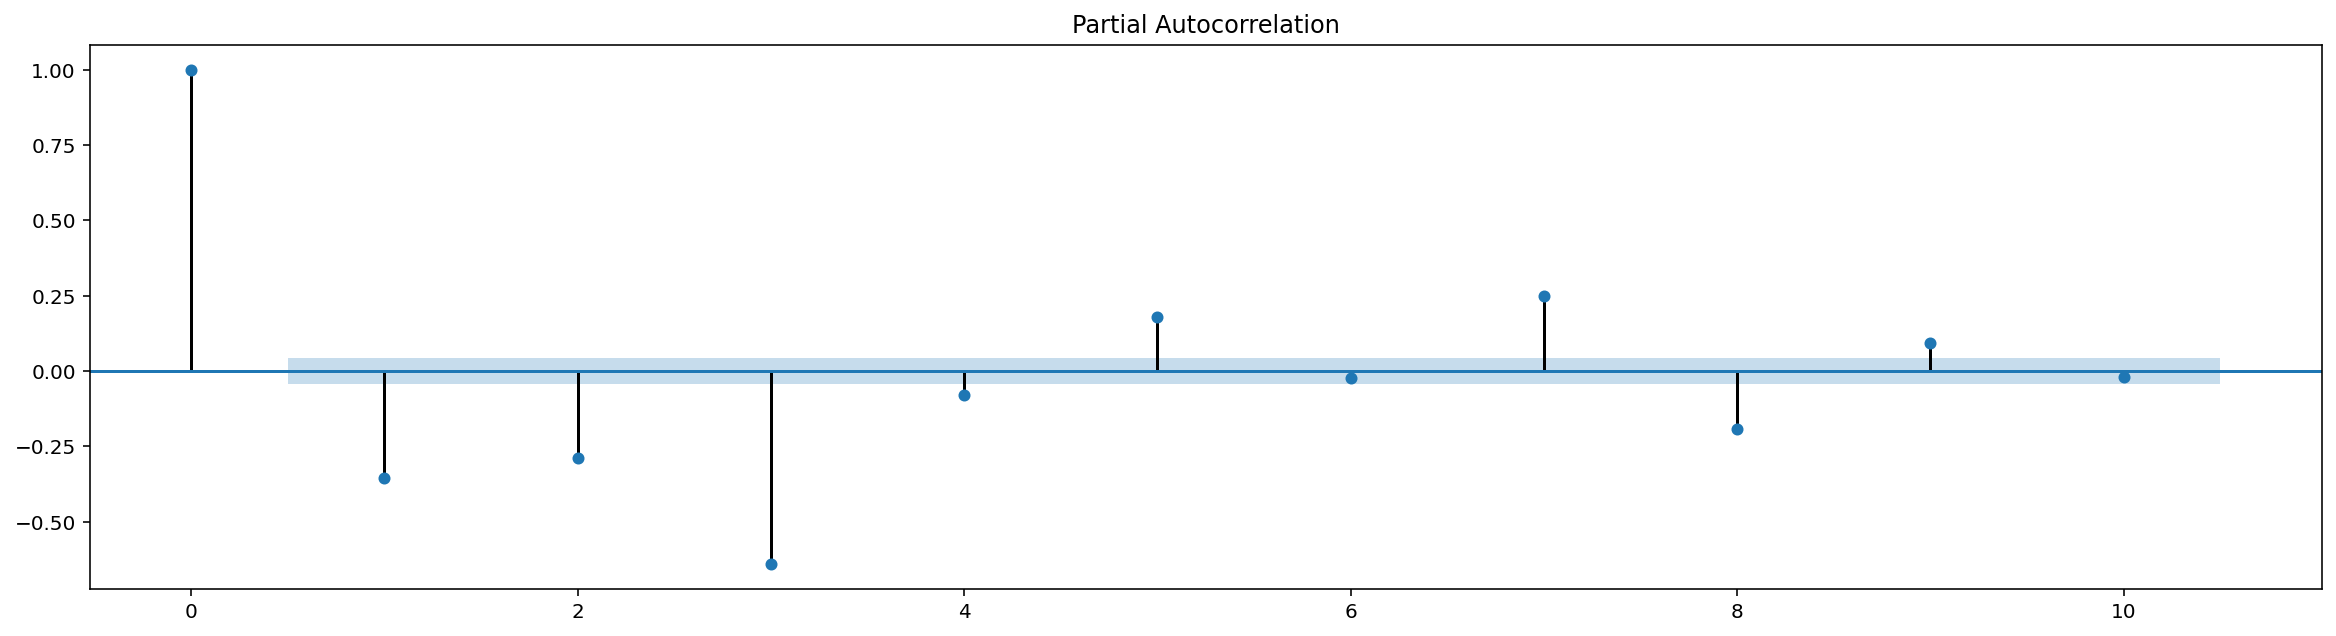

In [39]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax=plt.subplots(figsize=(20,5))
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

The above charts show that reading PACF gives us lag "p"=9 and reading ACF "q"=5. Let's use Statsmodel's ARIMA with these parameters to build a model. The way to evaluate the model is to look at AIC- see if it reduces or increases. The lower the AIC (i.e. the more negative it is), better is the model.

## Step 6: Building ARIMA Model
Since data is already been integrated and stationary, we only need to build ARMA model.

In [41]:
from statsmodels.tsa.arima.model import ARIMA

# Remember to use udiff-the differenced data rather than the original data
ar1=ARIMA(udiff.values, order=(9,0,5)).fit()
ar1.summary()

C:\Users\sonim\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sonim\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\sonim\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2109
Model:                 ARIMA(9, 0, 5)   Log Likelihood                1557.075
Date:                Tue, 04 Jan 2022   AIC                          -3082.150
Time:                        15:30:31   BIC                          -2991.687
Sample:                             0   HQIC                         -3049.023
                               - 2109                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.758      0.006       0.001       0.006
ar.L1         -0.2909      0.306     -0.951      0.342      -0.890       0.309
ar.L2         -0.1664      0.387     -0.429      0.668      -0.926       0.593
ar.L3         -0.0868      0.380     -0.229      0.819      -0.831       0.657
ar.L4          0.5387      0.300      1.793      0.073      -0.050       1.128
ar.L5         -0.0067      0.206     -0.032      0.974      -0.411       0.398
ar.L6         -0.0645      0.171     -0.378      0.706      -0.399       0.270
ar.L7         -0.0761      0.157     -0.486      0.627      -0.383       0.231
ar.L8         -0.3679      0.122     -3.010      0.003      -0.607      -0.128
ar.L9          0.1464      0.055      2.677      0.007       0.039       0.254
ma.L1         -0.2968      0.307     -0.968      0.333      -0.898       0.304
ma.L2         -0.1988      0.243     -0.820      0.412      -0.674       0.277
ma.L3         -0.1974      0.155     -1.275      0.202      -0.501       0.106
ma.L4          0.0150      0.107      0.140      0.889      -0.195       0.225
ma.L5          0.3004      0.105      2.850      0.004       0.094       0.507
sigma2         0.0134      0.000     59.445      0.000       0.013       0.014
===================================================================================
Ljung-Box (Q):                      100.72   Jarque-Bera (JB):              3613.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Our model doesnt do a good job predicting variance in the original data (peaks and valleys).

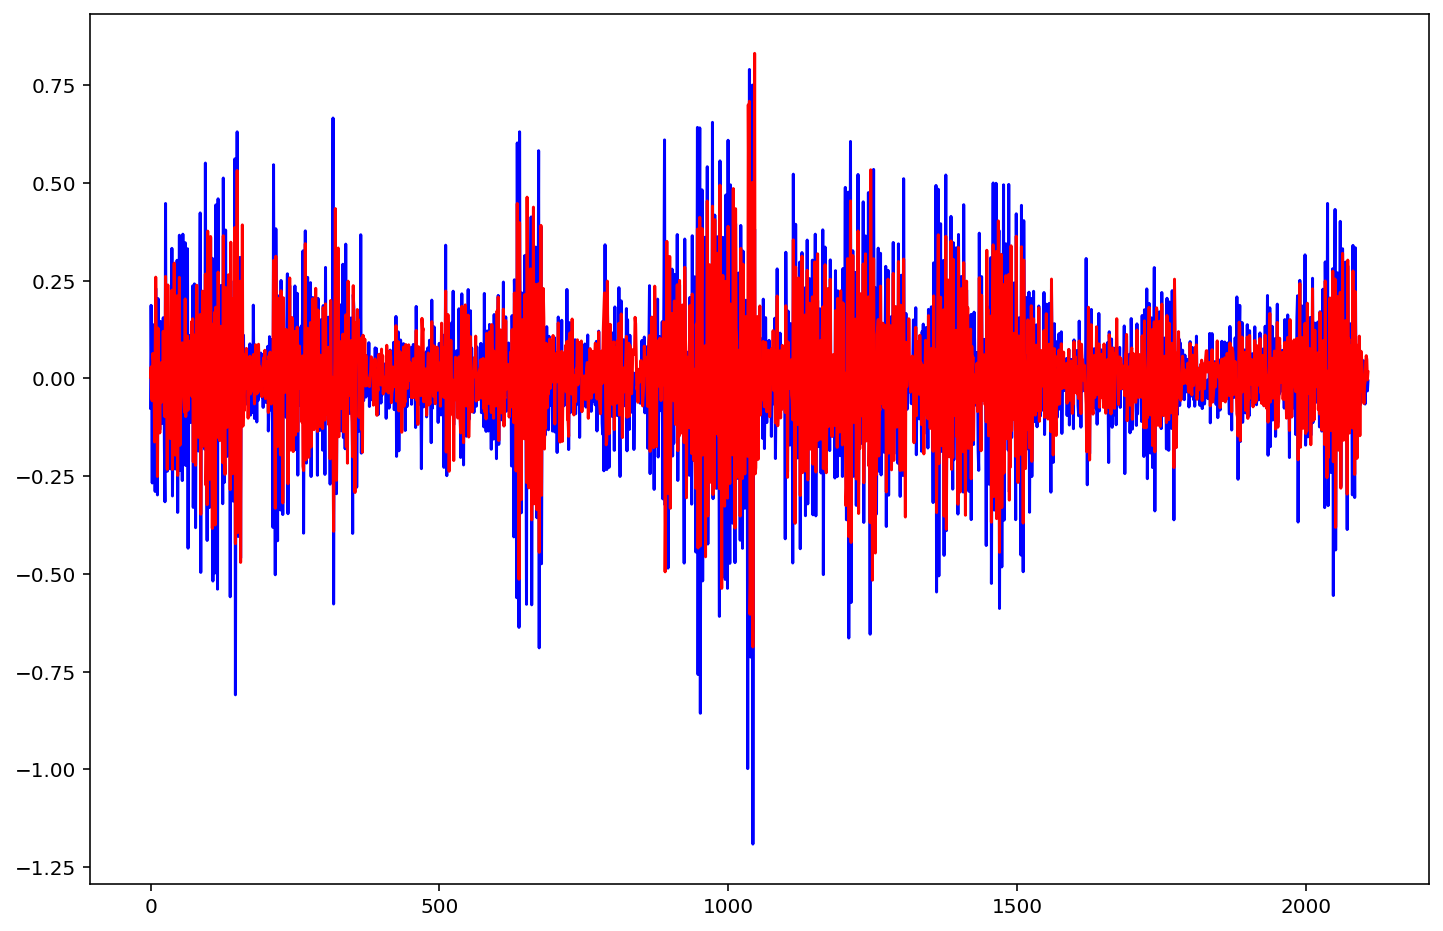

In [43]:
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')
preds=ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

Let's make a forcast 2 weeks ahead:

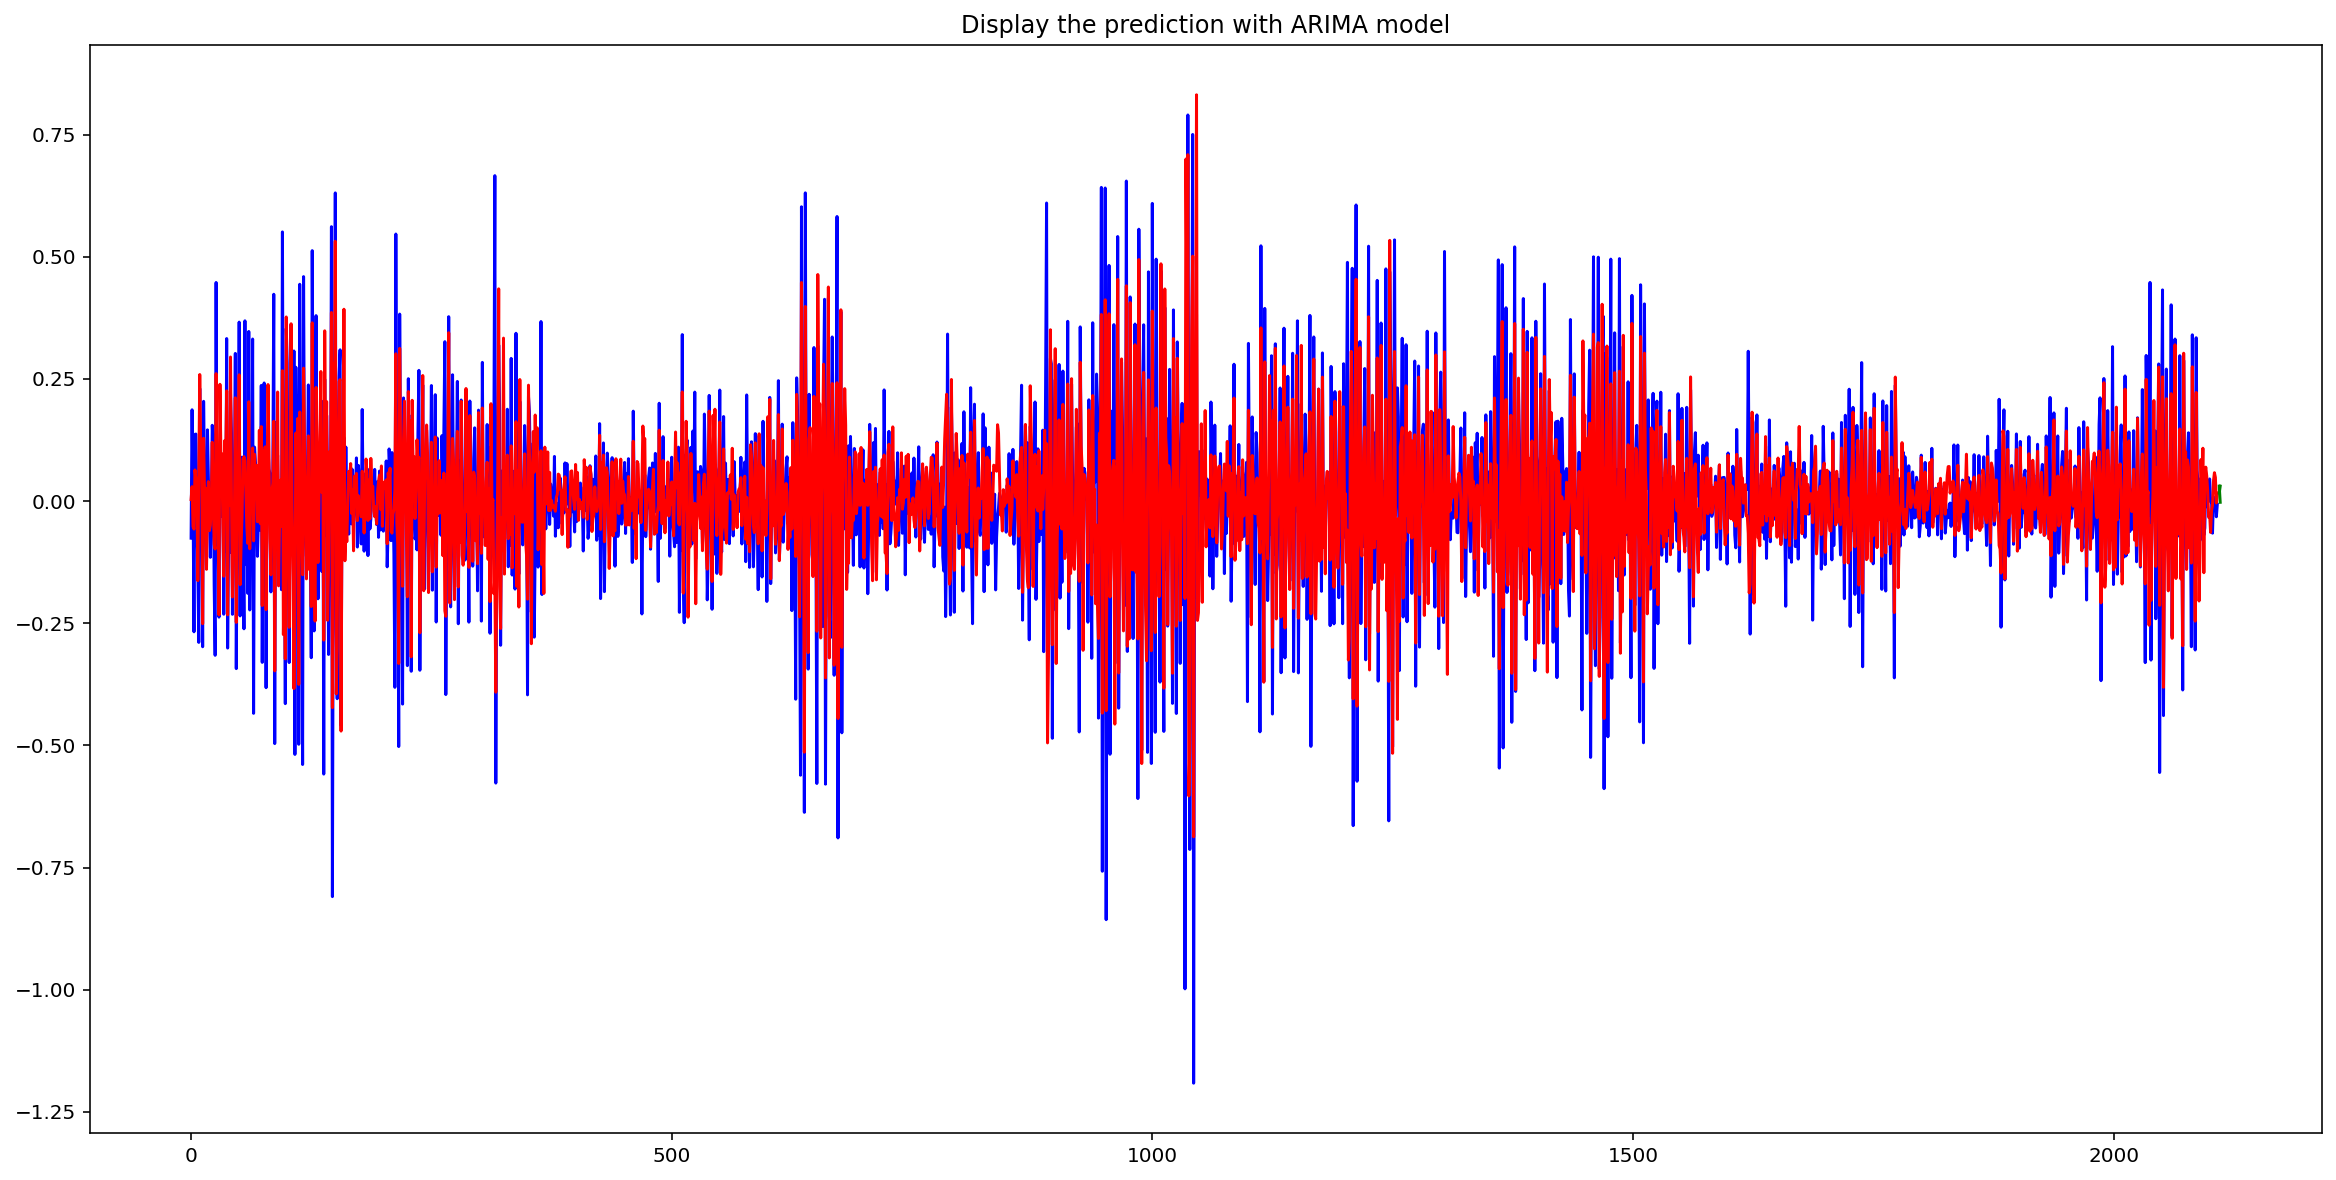

In [48]:
steps=2

forecast=ar1.forecast(steps=steps)

plt.figure(figsize=(20,10))
plt.plot(udiff.values, color='blue')

preds=ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1], forecast[0]]).T, index=range(len(udiff.values)+1, len(udiff.values)+3)), color='green')
plt.plot(pd.DataFrame(forcast, index=range(len(udiff.values)+1, len(udiff.values)+1+steps)), color='green')
plt.title('Display the prediction with ARIMA model')
plt.show()

In [49]:
forecast

array([ 0.03057507, -0.00243032])